<a href="https://colab.research.google.com/github/Shayantan1012/PV-Forcast-Project/blob/main/Updated_PV_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pytorch-lightning
!pip install pytorch_forecasting


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 64.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [5]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd

dataset=pd.read_csv('/content/drive/MyDrive/XAI /Other data/PVGen-1.csv')
dataset=pd.DataFrame(dataset)
print(dataset.head())

               Time  Energy delta[Wh]  GHI  temp  pressure  humidity  \
0  01-01-2017 00:00                 0  0.0   1.6      1021       100   
1  01-01-2017 00:15                 0  0.0   1.6      1021       100   
2  01-01-2017 00:30                 0  0.0   1.6      1021       100   
3  01-01-2017 00:45                 0  0.0   1.6      1021       100   
4  01-01-2017 01:00                 0  0.0   1.7      1020       100   

   wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  dayLength  \
0         4.9      0.0      0.0         100      0             0        450   
1         4.9      0.0      0.0         100      0             0        450   
2         4.9      0.0      0.0         100      0             0        450   
3         4.9      0.0      0.0         100      0             0        450   
4         5.2      0.0      0.0         100      0             0        450   

   SunlightTime/daylength  weather_type  hour  month  
0                     0.0            

In [8]:
print(dataset.isna().sum())
print(dataset.columns)
print(len(dataset.columns))

Time                      0
Energy delta[Wh]          0
GHI                       0
temp                      0
pressure                  0
humidity                  0
wind_speed                0
rain_1h                   0
snow_1h                   0
clouds_all                0
isSun                     0
sunlightTime              0
dayLength                 0
SunlightTime/daylength    0
weather_type              0
hour                      0
month                     0
dtype: int64
Index(['Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'weather_type',
       'hour', 'month'],
      dtype='object')
17


In [9]:
print(dataset.tail())

                    Time  Energy delta[Wh]   GHI  temp  pressure  humidity  \
196771  31-08-2022 16:45               118  23.7  18.6      1023        57   
196772  31-08-2022 17:00                82  15.6  18.5      1023        61   
196773  31-08-2022 17:15                51   8.0  18.5      1023        61   
196774  31-08-2022 17:30                24   2.1  18.5      1023        61   
196775  31-08-2022 17:45                 0   0.0  18.5      1023        61   

        wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  \
196771         3.8      0.0      0.0          52      1           780   
196772         4.2      0.0      0.0          60      1           795   
196773         4.2      0.0      0.0          60      1           810   
196774         4.2      0.0      0.0          60      1           825   
196775         4.2      0.0      0.0          60      0             0   

        dayLength  SunlightTime/daylength  weather_type  hour  month  
196771        825    

In [10]:
print(dataset.columns)
dataset['Time']

Index(['Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'weather_type',
       'hour', 'month'],
      dtype='object')


,Time
0,01-01-2017 00:00
1,01-01-2017 00:15
2,01-01-2017 00:30
3,01-01-2017 00:45
4,01-01-2017 01:00
...,...
196771,31-08-2022 16:45
196772,31-08-2022 17:00
196773,31-08-2022 17:15
196774,31-08-2022 17:30


<ipython-input-11-f7cebfe2ad8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Energy delta[MWh]']=filtered_data['Energy delta[Wh]']*1e-6


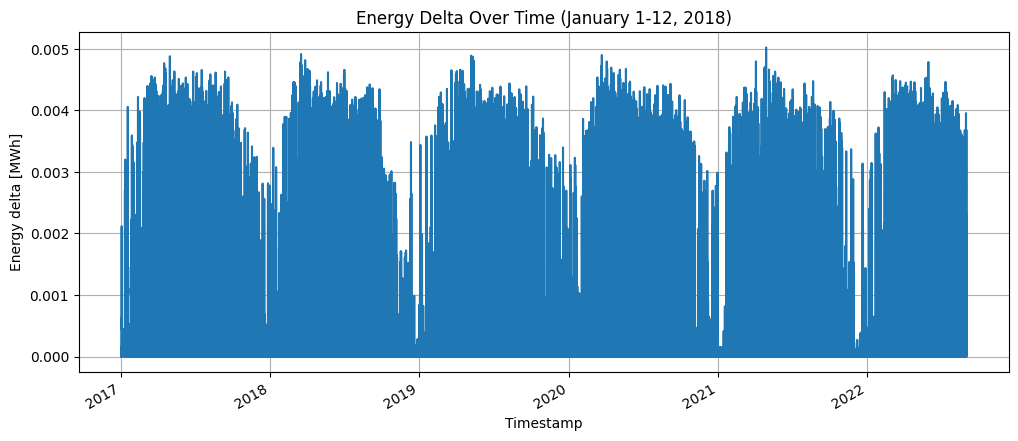

In [11]:
import matplotlib.pyplot as plt
start_time='2017-01-01'
end_time='2022-12-31'
dataset['Time'] = pd.to_datetime(dataset['Time'], format='%d-%m-%Y %H:%M')  # Adjust format to match your data
dataset.set_index('Time', inplace=True)
dataset = dataset[((dataset.index >= start_time) & (dataset.index <= end_time))]
filtered_data = dataset[start_time:end_time]  # Use YYYY-MM-DD format for slicing
filtered_data['Energy delta[MWh]']=filtered_data['Energy delta[Wh]']*1e-6

filtered_data['Energy delta[MWh]'].plot(figsize=(12, 5), title="Energy Delta Over Time (January 1-12, 2018)")
plt.xlabel("Timestamp")
plt.ylabel("Energy delta [MWh]")
plt.grid(True)
plt.show()



In [12]:
dataset.columns

Index(['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity', 'wind_speed',
       'rain_1h', 'snow_1h', 'clouds_all', 'isSun', 'sunlightTime',
       'dayLength', 'SunlightTime/daylength', 'weather_type', 'hour', 'month'],
      dtype='object')

In [13]:
Y=filtered_data['Energy delta[MWh]']
X=filtered_data.drop(columns=['Energy delta[MWh]','Energy delta[Wh]'],axis=1)


print("X Head->",X.head)
print("X Tail->",X.tail)


X Head-> <bound method NDFrame.head of                       GHI  temp  pressure  humidity  wind_speed  rain_1h  \
Time                                                                       
2017-01-01 00:00:00   0.0   1.6      1021       100         4.9      0.0   
2017-01-01 00:15:00   0.0   1.6      1021       100         4.9      0.0   
2017-01-01 00:30:00   0.0   1.6      1021       100         4.9      0.0   
2017-01-01 00:45:00   0.0   1.6      1021       100         4.9      0.0   
2017-01-01 01:00:00   0.0   1.7      1020       100         5.2      0.0   
...                   ...   ...       ...       ...         ...      ...   
2022-08-31 16:45:00  23.7  18.6      1023        57         3.8      0.0   
2022-08-31 17:00:00  15.6  18.5      1023        61         4.2      0.0   
2022-08-31 17:15:00   8.0  18.5      1023        61         4.2      0.0   
2022-08-31 17:30:00   2.1  18.5      1023        61         4.2      0.0   
2022-08-31 17:45:00   0.0  18.5      1023        

In [14]:
print(dataset.index)
print(type(dataset.index))

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:15:00',
               '2017-01-01 00:30:00', '2017-01-01 00:45:00',
               '2017-01-01 01:00:00', '2017-01-01 01:15:00',
               '2017-01-01 01:30:00', '2017-01-01 01:45:00',
               '2017-01-01 02:00:00', '2017-01-01 02:15:00',
               ...
               '2022-08-31 15:30:00', '2022-08-31 15:45:00',
               '2022-08-31 16:00:00', '2022-08-31 16:15:00',
               '2022-08-31 16:30:00', '2022-08-31 16:45:00',
               '2022-08-31 17:00:00', '2022-08-31 17:15:00',
               '2022-08-31 17:30:00', '2022-08-31 17:45:00'],
              dtype='datetime64[ns]', name='Time', length=196776, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [15]:
CorrelationMatrix=X.corr()
CorrelationMatrix

,GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
GHI,1.000000,0.492732,0.096392,-0.602186,0.017227,-0.048570,-0.051811,-0.188765,0.600326,0.540151,0.401115,0.471907,-0.163616,-0.083727,-0.039461
temp,0.492732,1.000000,-0.066909,-0.517358,-0.080258,0.073826,-0.123244,-0.117245,0.345600,0.504449,0.706510,0.382672,-0.088711,0.104091,0.250656
pressure,0.096392,-0.066909,1.000000,-0.120481,-0.313964,-0.201842,-0.135485,-0.263852,0.014872,0.006731,0.053127,0.001791,-0.319925,-0.002519,-0.061383
humidity,-0.602186,-0.517358,-0.120481,1.000000,-0.112949,0.126620,0.095623,0.285336,-0.389144,-0.598166,-0.416460,-0.527887,0.286863,-0.194924,0.117468
wind_speed,0.017227,-0.080258,-0.313964,-0.112949,1.000000,0.123506,0.072749,0.146116,0.082700,0.054580,-0.210064,0.092661,0.193744,-0.003593,-0.045010
rain_1h,-0.048570,0.073826,-0.201842,0.126620,0.123506,1.000000,-0.024276,0.173332,0.045241,0.059318,0.048428,0.050164,0.330671,0.011388,0.022221
snow_1h,-0.051811,-0.123244,-0.135485,0.095623,0.072749,-0.024276,1.000000,0.088428,-0.023257,-0.038293,-0.109050,-0.021457,0.143205,-0.004609,-0.080668
clouds_all,-0.188765,-0.117245,-0.263852,0.285336,0.146116,0.173332,0.088428,1.000000,-0.002928,-0.030415,-0.234957,0.004761,0.910932,-0.019384,0.066102
isSun,0.600326,0.345600,0.014872,-0.389144,0.082700,0.045241,-0.023257,-0.002928,1.000000,0.742715,0.270923,0.774424,0.024333,-0.150529,-0.024573
sunlightTime,0.540151,0.504449,0.006731,-0.598166,0.054580,0.059318,-0.038293,-0.030415,0.742715,1.000000,0.368712,0.957972,0.006140,0.144919,-0.028355


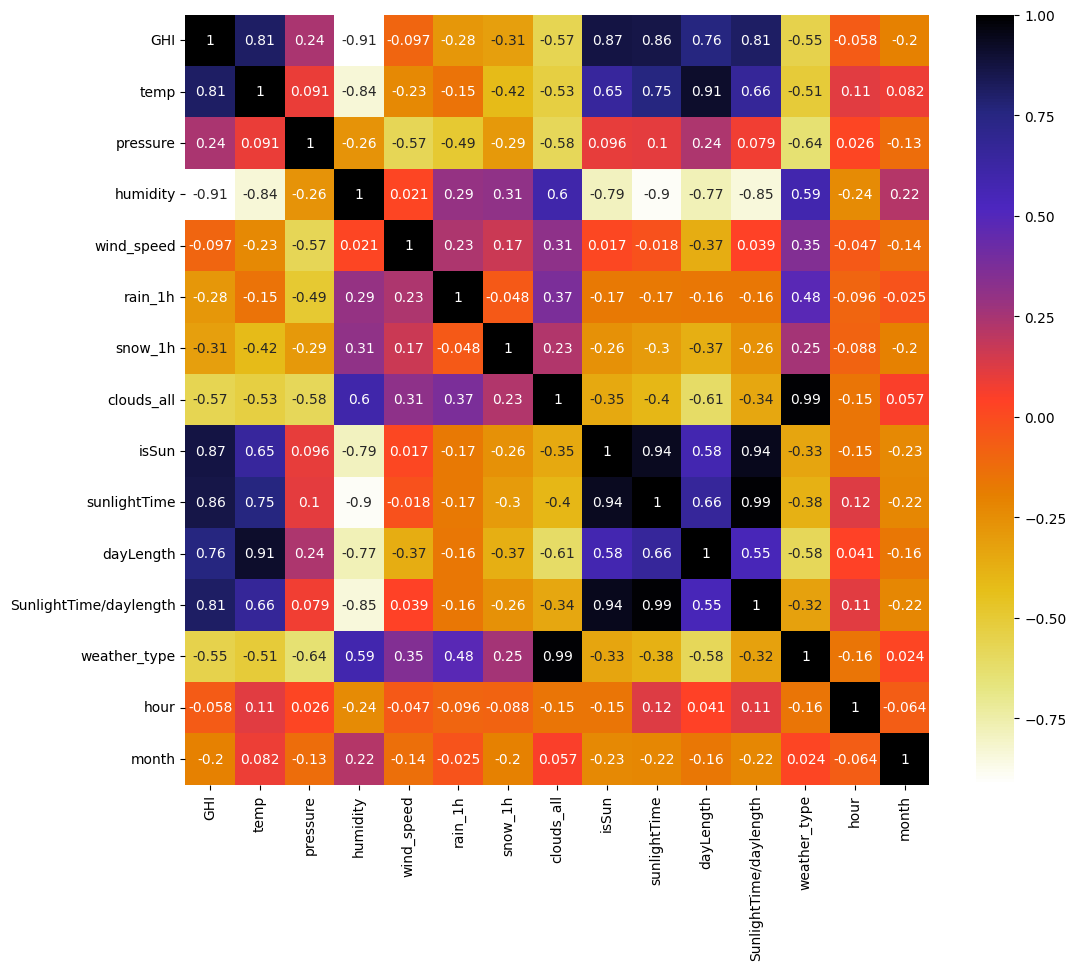

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = CorrelationMatrix.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [17]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


In [18]:
correlation=correlation(X,0.9)
print(correlation)
X=X.drop(correlation,axis=1)
X

{'weather_type', 'SunlightTime/daylength'}


,GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,hour,month
Time,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0,1
2017-01-01 00:15:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0,1
2017-01-01 00:30:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0,1
2017-01-01 00:45:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0,1
2017-01-01 01:00:00,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 16:45:00,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,16,8
2022-08-31 17:00:00,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,17,8
2022-08-31 17:15:00,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,17,8


In [19]:
!pip install mlxtend
!pip install --upgrade scikit-learn mlxtend


In [20]:
import sklearn
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [21]:
bakward_feature_selector = SequentialFeatureSelector(LinearRegression(n_jobs=1),
                                                    k_features=8,
                                                    forward=False,
                                                    floating=False,
                                                    verbose=2,
                                                    scoring= "r2",
                                                    cv= 5).fit(X,Y)

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   16.7s finished

[2025-05-24 16:54:47] Features: 12/8 -- score: 0.8478691095841286[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   13.8s finished

[2025-05-24 16:55:01] Features: 11/8 -- score: 0.8478407488741244[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished

[2025-05-24 16:55:06] Features: 10/8 -- score: 0.847797289371746[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished

[2025-05-24 16:55:12] Features: 9/8 -- score: 0.8477052092831985[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s finished

[2025-05-24 16:55:14] Features: 8/8 -- score: 0.8475987806046874

In [22]:
columns=bakward_feature_selector.k_feature_names_
columns


('GHI',
 'temp',
 'pressure',
 'humidity',
 'clouds_all',
 'isSun',
 'sunlightTime',
 'dayLength')

In [23]:
bakward_feature_selector.k_score_

np.float64(0.8475987806046874)

In [24]:
X = X[[col for col in X.columns if col in columns]]
X.head()

,GHI,temp,pressure,humidity,clouds_all,isSun,sunlightTime,dayLength
Time,,,,,,,,
2017-01-01 00:00:00,0.0,1.6,1021,100,100,0,0,450
2017-01-01 00:15:00,0.0,1.6,1021,100,100,0,0,450
2017-01-01 00:30:00,0.0,1.6,1021,100,100,0,0,450
2017-01-01 00:45:00,0.0,1.6,1021,100,100,0,0,450
2017-01-01 01:00:00,0.0,1.7,1020,100,100,0,0,450


In [25]:
print(dataset.head())

                     Energy delta[Wh]  GHI  temp  pressure  humidity  \
Time                                                                   
2017-01-01 00:00:00                 0  0.0   1.6      1021       100   
2017-01-01 00:15:00                 0  0.0   1.6      1021       100   
2017-01-01 00:30:00                 0  0.0   1.6      1021       100   
2017-01-01 00:45:00                 0  0.0   1.6      1021       100   
2017-01-01 01:00:00                 0  0.0   1.7      1020       100   

                     wind_speed  rain_1h  snow_1h  clouds_all  isSun  \
Time                                                                   
2017-01-01 00:00:00         4.9      0.0      0.0         100      0   
2017-01-01 00:15:00         4.9      0.0      0.0         100      0   
2017-01-01 00:30:00         4.9      0.0      0.0         100      0   
2017-01-01 00:45:00         4.9      0.0      0.0         100      0   
2017-01-01 01:00:00         5.2      0.0      0.0         100  

In [26]:
!pip install statsmodels

# ***Temporal Fusion Transformer***

In [34]:
X_ft=dataset
X_ft['Energy delta[MWh]']=X_ft['Energy delta[Wh]']*1e-6
X_ft=X_ft.drop('Energy delta[Wh]',axis=1)
X_ft.head()

,GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month,Energy delta[MWh]
Time,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1,0.0
2017-01-01 00:15:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1,0.0
2017-01-01 00:30:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1,0.0
2017-01-01 00:45:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1,0.0
2017-01-01 01:00:00,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.0,4,1,1,0.0


In [35]:
X_ft['time_interval'] = ((X_ft.index - X_ft.index.min()).total_seconds() / 60).astype(int)
X_ft['group_id']='group'
X_ft

,GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month,Energy delta[MWh],time_interval,group_id
Time,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1,0.000000,0,group
2017-01-01 00:15:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1,0.000000,15,group
2017-01-01 00:30:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1,0.000000,30,group
2017-01-01 00:45:00,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1,0.000000,45,group
2017-01-01 01:00:00,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1,0.000000,60,group
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 16:45:00,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8,0.000118,2978925,group
2022-08-31 17:00:00,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8,0.000082,2978940,group
2022-08-31 17:15:00,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8,0.000051,2978955,group


In [37]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 24
max_encoder_length = 7*24
training_cutoff = X_ft["time_interval"].max() - max_prediction_length

training = TimeSeriesDataSet(
    X_ft[lambda x: x.time_interval <= training_cutoff],
    time_idx="time_interval",
    target="Energy delta[MWh]",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group_id"],
    time_varying_known_reals=["time_interval", "month", 'hour'],
    time_varying_unknown_reals=['Energy delta[MWh]','GHI',
 'temp',
 'pressure',
 'humidity',
 'clouds_all',
 'isSun',
 'sunlightTime',
 'dayLength'],
    target_normalizer=GroupNormalizer(
        groups=["group_id"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)


validation = TimeSeriesDataSet.from_dataset(training, X_ft, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [38]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])

In [39]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 5.1 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.4 M  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 418 K  | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# **GRU MODEL**

In [ ]:
X_G=X
Y_G=Y
print(X.shape)
st_time='2018-01-01'
X_G

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_G

In [ ]:
#normalizing the data
scaler = MinMaxScaler()
# Convert Series to DataFrame
Y_G = Y_G.to_frame()
X_G=pd.concat([X_G,Y_G],axis=1)

scaled_values = scaler.fit_transform(X_G)
scaled_values.shape


In [ ]:
X_G
features_col=X_G.columns
print(features_col)

In [ ]:
Y_G

In [ ]:
figure, axes = plt.subplots(len(X_G.columns),1,figsize=(20, 20))
start_time = pd.to_datetime('2018-01-01')
end_time = pd.to_datetime('2018-12-31')

for ax,col in zip(axes,X_G.columns):
    ax.plot(X_G[col])
    ax.set_title(col)
    ax.axes.xaxis.set_visible(True)


plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        # Use numpy slicing instead of iloc
        X.append(data[i-window_size:i])  # Use array slicing
        y.append(data[i])  # Target value for this sequence
    return np.array(X), np.array(y)

X_G_scaled, Y_G_scaled = create_sequence(scaled_values, 60)

# Print the first sequence and corresponding target



In [ ]:
X_G_scaled.shape

In [ ]:
X_G_scaled.shape[1], X_G_scaled.shape[2]

In [ ]:
Y_G_scaled.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train_G, X_test_G, y_train_G, y_test_G = train_test_split(X_G_scaled, Y_G_scaled, test_size = 0.2, random_state=42,shuffle=False)
X_train_G.shape, y_train_G.shape, X_test_G.shape, y_test_G.shape

In [ ]:
Y_G_scaled

In [ ]:
X_test_G.size

In [ ]:

y_test_G=scaler.inverse_transform(y_test_G)


In [ ]:
y_test_G

In [ ]:
X_test_G.shape

In [ ]:
X_train_G.shape

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TabulerDataset(Dataset):
  def __init__(self ,X,y):
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.float32)
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [ ]:
loader=TabulerDataset(X_train_G,y_train_G)

dataloader=DataLoader(loader,batch_size=60,shuffle=False);

In [ ]:
len(dataloader)

In [ ]:

iterator = iter(dataloader)
X_batch, y_batch = next(iterator)

print(X_batch.shape)
print(y_batch.shape)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
class GRUblock(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super(GRUblock,self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.input_size=input_size
    self.gru1=nn.GRU(input_size, hidden_size, num_layers=1)
    self.gru2=nn.GRU(hidden_size, hidden_size, num_layers=1)
    self.fc=nn.Linear(hidden_size,9)
  def forward(self,x):
    h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)


    h1=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)


    x=x.to(device)
    out,(h1)=self.gru1(x,(h0))
    out,(h1)=self.gru2(out,(h1))
    out=self.fc(out[: ,-1 , :])
    return out



In [ ]:
X_train_G.shape

In [ ]:
gru=GRUblock(X_train_G.shape[2],64,1).to(device)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(gru.parameters(),lr=0.001)

In [ ]:
def train_gru(model,dataloader,loss_fn,optimizer,device,epochs):
  for epochs in range(epochs):
    total_loss=0
    for i,(X_batch,y_batch) in enumerate(dataloader):
      if(i==len(dataloader)-1):
        break
      X_batch=X_batch.to(device)
      y_batch=y_batch.to(device)

      y_pred=model(X_batch)

      loss=loss_fn(y_pred,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss+=loss
    avg_loss=total_loss/len(dataloader)
    print(f'The avg loss in EPOCH:{epochs} is {avg_loss}')



In [ ]:
# train_gru(gru,dataloader,loss_fn,optimizer,device,30)

In [ ]:
# torch.save(gru.state_dict(),'/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/gru_model.pt')

In [ ]:
model_gru=GRUblock(X_train_G.shape[2],64,1).to(device)
model_gru.load_state_dict(torch.load('/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/gru_model.pt'))
model_gru.eval()

In [ ]:
X_test_G.shape

In [ ]:
y_test_G.shape

In [ ]:
test_loader=TabulerDataset(X_test_G,y_test_G)
test_loader=DataLoader(test_loader,batch_size=60,shuffle=False)


In [ ]:
len(test_loader)

In [ ]:
gru.eval()
cou=0
predicted=[]
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(test_loader):
        if i == (len(test_loader) - 1):
          continue
        X_batch = X_batch.to(device)
        yPred = model_gru(X_batch)
        predicted.append(yPred.cpu().numpy())




In [ ]:

predicted=np.array(predicted)

In [ ]:
predicted.shape

In [ ]:
predicted=predicted.reshape(-1,9)
predicted.shape

In [ ]:
yPredDF = pd.DataFrame(predicted)
y_pred_inv_df_gru =yPredDF
y_pred_inv_df_gru.columns=X_G.columns




In [ ]:
y_pred_inv_df_gru=scaler.inverse_transform(y_pred_inv_df_gru)

In [ ]:
y_pred_inv_df_gru=pd.DataFrame(y_pred_inv_df_gru)
y_pred_inv_df_gru.columns=X_G.columns

In [ ]:
y_pred_inv_df_gru.shape

In [ ]:
y_test_G.shape

In [ ]:
# Trim index so its length becomes exactly 39300
trimmed_index = X_G.index[-len(y_test_G):][:-44]

# Now assign this to prediction DataFrame
y_pred_inv_df_gru.index = trimmed_index

In [ ]:
y_pred_inv_df_gru

In [ ]:
y_test_G=pd.DataFrame(y_test_G)
y_test_G.columns=X_G.columns
y_test_G=y_test_G[:-44]
y_test_G.index=trimmed_index
y_test_G

In [ ]:
def mean_squared_error(y_true,y_pred):
  return np.mean((y_true-y_pred)**2)

def mean_absolute_error(y_true,y_pred):
  return np.mean(np.abs(y_true-y_pred))

def root_mean_squared_error(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))


In [ ]:
mse_g=mean_squared_error(y_test_G['Energy delta[MWh]'],y_pred_inv_df_gru['Energy delta[MWh]']);
mae_g=mean_absolute_error(y_test_G['Energy delta[MWh]'],y_pred_inv_df_gru['Energy delta[MWh]']);
rmse_g=root_mean_squared_error(y_test_G['Energy delta[MWh]'],y_pred_inv_df_gru['Energy delta[MWh]']);
print(f'MSE:{mse_g}\nMAE:{mae_g}\nRMSE:{rmse_g}')
plt.figure(figsize=(10, 6))
errors={'MSE' : mse_g , 'MAE' : mae_g ,'RMSE' : rmse_g }
plt.bar(errors.keys(),errors.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()


In [ ]:
fig ,axes=plt.subplots(len(y_pred_inv_df_gru.columns),1,figsize=(20,20))
for ax,col in zip(axes,y_pred_inv_df_gru.columns):
    ax.plot(y_test_G[col],color='red',label=f'Actual {col}')
    ax.plot(y_pred_inv_df_gru[col],color='blue',label=f'Predicted {col}')
    ax.legend()
    ax.set_title(col)
    ax.set_title(col)

plt.tight_layout()
plt.show()


# **LSTM MODEL**

In [ ]:
X_L=X
Y_L=Y
print(X.shape)
st_time='2018-01-01'
X_L

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_L

In [ ]:
#normalizing the data
scaler = MinMaxScaler()
# Convert Series to DataFrame
Y_L = Y_L.to_frame()
X_L=pd.concat([X_L,Y_L],axis=1)

scaled_values = scaler.fit_transform(X_L)
scaled_values.shape


In [ ]:
X_L
features_col=X_L.columns
print(features_col)

In [ ]:
Y_L

In [ ]:
figure, axes = plt.subplots(len(X_L.columns),1,figsize=(20, 20))
start_time = pd.to_datetime('2018-01-01')
end_time = pd.to_datetime('2018-12-31')

for ax,col in zip(axes,X_L.columns):
    ax.plot(X_L[col])
    ax.set_title(col)
    ax.axes.xaxis.set_visible(True)


plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        # Use numpy slicing instead of iloc
        X.append(data[i-window_size:i])  # Use array slicing
        y.append(data[i])  # Target value for this sequence
    return np.array(X), np.array(y)

X_L_scaled, Y_L_scaled = create_sequence(scaled_values, 60)

# Print the first sequence and corresponding target



In [ ]:
X_L_scaled.shape

In [ ]:
X_L_scaled.shape[1], X_L_scaled.shape[2]

In [ ]:
Y_L_scaled.shape

In [ ]:
#train-test-split

X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(X_L_scaled, Y_L_scaled, test_size = 0.2, random_state=42,shuffle=False)
X_train_L.shape, y_train_L.shape, X_test_L.shape, y_test_L.shape

In [ ]:
Y_L_scaled

In [ ]:
X_test_L.size

In [ ]:

y_test_L=scaler.inverse_transform(y_test_L)


In [ ]:
y_test_L

In [ ]:
X_test_L.shape

In [ ]:
X_train_L.shape

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TabulerDataset(Dataset):
  def __init__(self ,X,y):
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.float32)
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [ ]:
loader=TabulerDataset(X_train_L,y_train_L)

dataloader=DataLoader(loader,batch_size=60,shuffle=False);

In [ ]:
len(dataloader)

In [ ]:

iterator = iter(dataloader)
X_batch, y_batch = next(iterator)

print(X_batch.shape)
print(y_batch.shape)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
class LSTMblock(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super(LSTMblock,self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.input_size=input_size
    self.lstm1=nn.LSTM(input_size, hidden_size, num_layers=1)
    self.lstm2=nn.LSTM(hidden_size, hidden_size, num_layers=1)
    self.fc=nn.Linear(hidden_size,9)
  def forward(self,x):
    h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)

    h1=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    c1=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)

    x=x.to(device)
    out,(h1,c1)=self.lstm1(x,(h0,c0))
    out,(h1,c1)=self.lstm2(out,(h1,c1))
    out=self.fc(out[: ,-1 , :])
    return out



In [ ]:
X_train_L.shape

In [ ]:
lstm=LSTMblock(X_train_L.shape[2],64,1).to(device)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(lstm.parameters(),lr=0.001)


In [ ]:
def train_lstm(model,dataloader,loss_fn,optimizer,device,epochs):
  for epochs in range(epochs):
    total_loss=0
    for i,(X_batch,y_batch) in enumerate(dataloader):
      if(i==len(dataloader)-1):
        break
      X_batch=X_batch.to(device)
      y_batch=y_batch.to(device)

      y_pred=model(X_batch)

      loss=loss_fn(y_pred,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss+=loss
    avg_loss=total_loss/len(dataloader)
    print(f'The avg loss in EPOCH:{epochs} is {avg_loss}')



In [ ]:
# train_lstm(lstm,dataloader,loss_fn,optimizer,device,30)

In [ ]:
# torch.save(lstm.state_dict(),'/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/lstm_model')

In [ ]:
model_lstm=LSTMblock(X_train_L.shape[2],64,1).to(device)
model_lstm.load_state_dict(torch.load('/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/lstm_model'))
model_lstm.eval()

In [ ]:
X_test_L.shape

In [ ]:
y_test_L.shape

In [ ]:
test_loader=TabulerDataset(X_test_L,y_test_L)
test_loader=DataLoader(test_loader,batch_size=60,shuffle=False)


In [ ]:
len(test_loader)

In [ ]:
lstm.eval()
cou=0
predicted=[]
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(test_loader):
        if i == (len(test_loader) - 1):
          continue
        X_batch = X_batch.to(device)
        yPred = model_lstm(X_batch)
        predicted.append(yPred.cpu().numpy())




In [ ]:

predicted=np.array(predicted)

In [ ]:
predicted.shape

In [ ]:
predicted=predicted.reshape(-1,9)
predicted.shape

In [ ]:
yPredDF = pd.DataFrame(predicted)
y_pred_inv_df =yPredDF
y_pred_inv_df.columns=X_L.columns




In [ ]:
y_pred_inv_df=scaler.inverse_transform(y_pred_inv_df)

In [ ]:
y_pred_inv_df=pd.DataFrame(y_pred_inv_df)
y_pred_inv_df.columns=X_L.columns

In [ ]:
y_pred_inv_df.shape

In [ ]:
y_test_L.shape

In [ ]:
# Trim index so its length becomes exactly 39300
trimmed_index = X_L.index[-len(y_test_L):][:-44]

# Now assign this to prediction DataFrame
y_pred_inv_df.index = trimmed_index

In [ ]:
y_pred_inv_df

In [ ]:
y_test_L=pd.DataFrame(y_test_L)
y_test_L.columns=X_L.columns
y_test_L=y_test_L[:-44]
y_test_L.index=trimmed_index
y_test_L

In [ ]:
def mean_squared_error(y_true,y_pred):
  return np.mean((y_true-y_pred)**2)

def mean_absolute_error(y_true,y_pred):
  return np.mean(np.abs(y_true-y_pred))

def root_mean_squared_error(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))


In [ ]:
mse_l=mean_squared_error(y_test_L['Energy delta[MWh]'],y_pred_inv_df['Energy delta[MWh]']);
mae_l=mean_absolute_error(y_test_L['Energy delta[MWh]'],y_pred_inv_df['Energy delta[MWh]']);
rmse_l=root_mean_squared_error(y_test_L['Energy delta[MWh]'],y_pred_inv_df['Energy delta[MWh]']);
print(f'MSE:{mse_l}\nMAE:{mae_l}\nRMSE:{rmse_l}')
plt.figure(figsize=(10, 6))
errors={'MSE' : mse_l , 'MAE' : mae_l ,'RMSE' : rmse_l }
plt.bar(errors.keys(),errors.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()


In [ ]:
fig ,axes=plt.subplots(len(y_pred_inv_df.columns),1,figsize=(20,20))
for ax,col in zip(axes,y_pred_inv_df.columns):
    ax.plot(y_test_L[col],color='red',label=f'Actual {col}')
    ax.plot(y_pred_inv_df[col],color='blue',label=f'Predicted {col}')
    ax.legend()
    ax.set_title(col)
    ax.set_title(col)

plt.tight_layout()
plt.show()


# **TRANSFORMER MODEL**

In [ ]:
X_T=X
Y_T=Y
print(X.shape)
st_time='2018-01-01'
X_T

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_T

In [ ]:
#normalizing the data
scaler = MinMaxScaler()
# Convert Series to DataFrame
Y_T = Y_T.to_frame()
X_T=pd.concat([X_T,Y_T],axis=1)

scaled_values = scaler.fit_transform(X_T)
scaled_values.shape


In [ ]:
X_T
features_col=X_T.columns
print(features_col)

In [ ]:
Y_T

In [ ]:
figure, axes = plt.subplots(len(X_T.columns),1,figsize=(20, 20))
start_time = pd.to_datetime('2018-01-01')
end_time = pd.to_datetime('2018-12-31')

for ax,col in zip(axes,X_T.columns):
    ax.plot(X_T[col])
    ax.set_title(col)
    ax.axes.xaxis.set_visible(True)


plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        # Use numpy slicing instead of iloc
        X.append(data[i-window_size:i])  # Use array slicing
        y.append(data[i])  # Target value for this sequence
    return np.array(X), np.array(y)

X_T_scaled, Y_T_scaled = create_sequence(scaled_values, 60)

# Print the first sequence and corresponding target



In [ ]:
X_T_scaled.shape

In [ ]:
X_T_scaled.shape[1], X_T_scaled.shape[2]

In [ ]:
Y_T_scaled.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(X_L_scaled, Y_L_scaled, test_size = 0.2, random_state=42,shuffle=False)
X_train_T.shape, y_train_T.shape, X_test_T.shape, y_test_T.shape

In [ ]:
Y_T_scaled

In [ ]:
X_test_T.size

In [ ]:

y_test_T=scaler.inverse_transform(y_test_T)


In [ ]:
y_test_T

In [ ]:
X_test_T.shape

In [ ]:
X_train_T.shape

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TabulerDataset(Dataset):
  def __init__(self ,X,y):
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.float32)
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [ ]:
loader=TabulerDataset(X_train_T,y_train_T)

dataloader=DataLoader(loader,batch_size=60,shuffle=False);

In [ ]:
len(dataloader)

In [ ]:

iterator = iter(dataloader)
X_batch, y_batch = next(iterator)

print(X_batch.shape)
print(y_batch.shape)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=9, d_model=60, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 9)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

transformer = TransformerModel().to(device)

In [ ]:
X_train_T.shape

In [ ]:
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(transformer.parameters(),lr=0.001)

In [ ]:
def train_transformer(model,dataloader,loss_fn,optimizer,device,epochs):
  for epochs in range(epochs):
    total_loss=0
    for i,(X_batch,y_batch) in enumerate(dataloader):
      if(i==len(dataloader)-1):
        break
      X_batch=X_batch.to(device)
      y_batch=y_batch.to(device)

      y_pred=model(X_batch)

      loss=loss_fn(y_pred,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss+=loss
    avg_loss=total_loss/len(dataloader)
    print(f'The avg loss in EPOCH:{epochs} is {avg_loss}')



In [ ]:
# train_transformer(transformer,dataloader,loss_fn,optimizer,device,30)

In [ ]:
# torch.save(transformer.state_dict(),'/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/transformer_model.pt')

In [ ]:
model_transformer=TransformerModel().to(device)
model_transformer.load_state_dict(torch.load('/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/transformer_model.pt'))
model_transformer.eval()

In [ ]:
X_test_T.shape

In [ ]:
y_test_T.shape

In [ ]:
test_loader=TabulerDataset(X_test_T,y_test_T)
test_loader=DataLoader(test_loader,batch_size=60,shuffle=False)


In [ ]:
len(test_loader)

In [ ]:
transformer.eval()
cou=0
predicted=[]
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(test_loader):
        if i == (len(test_loader) - 1):
          continue
        X_batch = X_batch.to(device)
        yPred = model_transformer(X_batch)
        predicted.append(yPred.cpu().numpy())




In [ ]:

predicted=np.array(predicted)

In [ ]:
predicted.shape

In [ ]:
predicted=predicted.reshape(-1,9)
predicted.shape

In [ ]:
yPredDF = pd.DataFrame(predicted)
y_pred_inv_df_t =yPredDF
y_pred_inv_df_t.columns=X_T.columns




In [ ]:
y_pred_inv_df_t=scaler.inverse_transform(y_pred_inv_df_t)

In [ ]:
y_pred_inv_df_t=pd.DataFrame(y_pred_inv_df_t)
y_pred_inv_df_t.columns=X_T.columns

In [ ]:
y_pred_inv_df_t.shape

In [ ]:
y_test_T.shape

In [ ]:
# Trim index so its length becomes exactly 39300
trimmed_index = X_T.index[-len(y_test_T):][:-44]

# Now assign this to prediction DataFrame
y_pred_inv_df_t.index = trimmed_index

In [ ]:
y_pred_inv_df_t

In [ ]:
y_test_T=pd.DataFrame(y_test_T)
y_test_T.columns=X_T.columns
y_test_T=y_test_T[:-44]
y_test_T.index=trimmed_index
y_test_T

In [ ]:
def mean_squared_error(y_true,y_pred):
  return np.mean((y_true-y_pred)**2)

def mean_absolute_error(y_true,y_pred):
  return np.mean(np.abs(y_true-y_pred))

def root_mean_squared_error(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))


In [ ]:
mse_t=mean_squared_error(y_test_T['Energy delta[MWh]'],y_pred_inv_df_t['Energy delta[MWh]']);
mae_t=mean_absolute_error(y_test_T['Energy delta[MWh]'],y_pred_inv_df_t['Energy delta[MWh]']);
rmse_t=root_mean_squared_error(y_test_T['Energy delta[MWh]'],y_pred_inv_df_t['Energy delta[MWh]']);
print(f'MSE:{mse_t}\nMAE:{mae_t}\nRMSE:{rmse_t}')
plt.figure(figsize=(10, 6))
errors={'MSE' : mse_t , 'MAE' : mae_t ,'RMSE' : rmse_t }
plt.bar(errors.keys(),errors.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()


In [ ]:
fig ,axes=plt.subplots(len(y_pred_inv_df_t.columns),1,figsize=(20,20))
for ax,col in zip(axes,y_pred_inv_df_t.columns):
    ax.plot(y_test_T[col],color='red',label=f'Actual {col}')
    ax.plot(y_pred_inv_df_t[col],color='blue',label=f'Predicted {col}')
    ax.legend()
    ax.set_title(col)
    ax.set_title(col)

plt.tight_layout()
plt.show()


# ***ERROR COMPARISION***


In [ ]:
plt.figure(figsize=(12, 7))
error_com_mse={'LSTM':mse_l , 'GRU':mse_g , 'TRANSFORMER':mse_t}
plt.bar(error_com_mse.keys(),error_com_mse.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()

In [ ]:
plt.figure(figsize=(12, 7))
error_com_mae={'LSTM':mae_l , 'GRU':mae_g , 'TRANSFORMER':mae_t}
plt.bar(error_com_mae.keys(),error_com_mae.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()

In [ ]:
plt.figure(figsize=(12, 7))
error_com_rmse={'LSTM':rmse_l , 'GRU':rmse_g , 'TRANSFORMER':rmse_t}
plt.bar(error_com_rmse.keys(),error_com_rmse.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()

# NOW CREATE A DATASET FOR ENSEMBLE ***MODEL***

In [ ]:
PredG=y_pred_inv_df_gru
PredL=y_pred_inv_df
PredT=y_pred_inv_df_t


In [ ]:
Y=Y.to_frame()
Y

In [ ]:
# Step 1: Convert all variables into DataFrames with column names
y_train_G = pd.DataFrame(PredG['Energy delta[MWh]'])
y_train_L = pd.DataFrame(PredL['Energy delta[MWh]'])
y_train_T = pd.DataFrame(PredT['Energy delta[MWh]'])
y_train_R = pd.DataFrame(Y['Energy delta[MWh]'])

# Step 2: Concatenate the DataFrames along columns
y_train_combined = pd.concat([y_train_G, y_train_L, y_train_T, y_train_R], axis=1)
y_train_combined.columns = ['GRU', 'LSTM', 'Transformer', 'Actual Value']


In [ ]:
y_train_combined.dropna(inplace=True)

In [ ]:
y_train_combined

In [ ]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(12, 7))

# Plot model predictions and actual values
plt.plot(y_train_combined['GRU'], color='blue', linestyle='-', label='GRU')
plt.plot(y_train_combined['LSTM'], color='green', linestyle='--', label='LSTM')
plt.plot(y_train_combined['Transformer'], color='black', linestyle='-.', label='TRANSFORMER')
plt.plot(y_train_combined['Actual Value'], color='red', linestyle='-', label='Actual Value')

# Titles and labels
plt.title("Model Predictions vs Actual Values", fontsize=16, fontweight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Energy delta [MWh]", fontsize=12)

# Grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add a legend box
plt.legend(loc='upper right', fontsize=12, frameon=True, edgecolor='black', fancybox=True, shadow=True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))

plt.plot(y_train_combined['GRU'], color='blue', linestyle='-', label='GRU')
plt.plot(y_train_combined['LSTM'], color='green', linestyle='--', label='LSTM')
plt.plot(y_train_combined['Transformer'], color='black', linestyle='-.', label='TRANSFORMER')
plt.plot(y_train_combined['Actual Value'], color='red', linestyle='-', linewidth=1, label='Actual Value')
plt.title("Model Predictions vs Actual Values", fontsize=16, fontweight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Energy delta [MWh]", fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



# ***NOW BEGIN WITH  ENSEMBLE MODEL***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(y_train_combined.drop('Actual Value',axis=1),y_train_combined['Actual Value'], test_size = 0.1, random_state=42,shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
X_test

# ***MLP***

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.model(x)




In [ ]:
# Training function
def train_model(model, X_train, y_train, epochs=10, batch_size=10, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
     # ✅ Convert to NumPy first if input is DataFrame/Series
    if hasattr(X_train, 'values'):
        X_train = X_train.values
    if hasattr(y_train, 'values'):
        y_train = y_train.values

    # Convert data to tensors and move to device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_mae = 0.0

        for i in range(0, len(X_train_tensor), batch_size):
            x_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(x_batch)

            loss = criterion(outputs, y_batch)

            mae = torch.mean(torch.abs(outputs - y_batch))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mae += mae.item()

        avg_loss = total_loss / len(X_train_tensor)
        avg_mae = total_mae / len(X_train_tensor)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.8f} - MAE: {avg_mae:.8f}")

    return model

In [ ]:
model_mlp = MLPModel()
# trained_model = train_model(model_mlp, X_train, y_train, epochs=50, batch_size=10)

In [ ]:
# Save model weights
# torch.save(model_mlp.state_dict(), '/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/mlp_model.pt')

In [ ]:
model_mlp=MLPModel().to(device)
model_mlp.load_state_dict(torch.load('/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/mlp_model.pt'))
model_mlp.eval()

In [ ]:
model_mlp_res=model_mlp(torch.tensor(X_test.values).to(device))


In [ ]:
model_mlp_res=model_mlp_res.cpu().detach().numpy()

In [ ]:
MLPdf = pd.DataFrame(model_mlp_res, columns=["MLP Output"])

In [ ]:
MLPdf.index=X_test.index
MLPdf

In [ ]:
def mean_squared_error(y_true,y_pred):
  return np.mean((y_true-y_pred)**2)

def mean_absolute_error(y_true,y_pred):
  return np.mean(np.abs(y_true-y_pred))

def root_mean_squared_error(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))


In [ ]:
mse_m=mean_squared_error(y_test_T['Energy delta[MWh]'],MLPdf['MLP Output']);
mae_m=mean_absolute_error(y_test_T['Energy delta[MWh]'],MLPdf['MLP Output']);
rmse_m=root_mean_squared_error(y_test_T['Energy delta[MWh]'],MLPdf['MLP Output']);
print(f'MSE:{mse_m}\nMAE:{mae_m}\nRMSE:{rmse_m}')
plt.figure(figsize=(10, 6))
errors={'MSE' : mse_m , 'MAE' : mae_m ,'RMSE' : rmse_m }
plt.bar(errors.keys(),errors.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()


# ***CNN MODEL***

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class CNN_model(nn.Module):
  def __init__(self):
    super(CNN_model,self).__init__()
    self.conv1=nn.Conv1d(out_channels=128,kernel_size=2,in_channels=1)
    self.pool=nn.MaxPool1d(kernel_size=2)
    self.flatten=nn.Flatten()
    self.fc1=nn.Linear(in_features=128,out_features=64)
    self.fc2=nn.Linear(in_features=64,out_features=1)

  def forward(self,x):
    x=self.conv1(x)
    x=self.pool(x)
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.fc2(x)
    return x


In [ ]:
def train_cnn_model(model, X_train, y_train, epochs=10, batch_size=1, learning_rate=0.001):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Ensure data is NumPy array first
    if hasattr(X_train, 'values'):
        X_train = X_train.values
    if hasattr(y_train, 'values'):
        y_train = y_train.values

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 3).to(device)  # (batch_size, 1, 3)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)     # (batch_size, 1)

    history = {'loss': [], 'mae': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_mae = 0.0

        for i in range(0, len(X_train_tensor), batch_size):
            x_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(x_batch)

            loss = loss_fn(outputs, y_batch)
            mae = torch.mean(torch.abs(outputs - y_batch))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mae += mae.item()

        avg_loss = total_loss / len(X_train_tensor)
        avg_mae = total_mae / len(X_train_tensor)

        history['loss'].append(avg_loss)
        history['mae'].append(avg_mae)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.8f} - MAE: {avg_mae:.8f}")

    return model, history


In [ ]:
model_cnn = CNN_model().to(device)
# trained_model_cnn, history = train_cnn_model(model_cnn, X_train, y_train, epochs=80, batch_size=10)


In [ ]:
# Save model weights
# torch.save(model_cnn.state_dict(), '/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/cnn_model.pt')

In [ ]:
model_cnn=CNN_model().to(device)
model_cnn.load_state_dict(torch.load('/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/cnn_model.pt'))
model_cnn.eval()

In [ ]:
X_train

In [ ]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).view(-1, 1, 3).to(device)  # (batch_size, 1, 3)
model_cnn_res=model_cnn(X_test_tensor).cpu().detach().numpy()

In [ ]:
model_cnn_ = model_cnn_res.reshape(-1, 1)
CNNdf = pd.DataFrame(model_cnn_, columns=["CNN Output"])

In [ ]:
CNNdf.index=X_test.index
CNNdf

In [ ]:
def mean_squared_error(y_true,y_pred):
  return np.mean((y_true-y_pred)**2)

def mean_absolute_error(y_true,y_pred):
  return np.mean(np.abs(y_true-y_pred))

def root_mean_squared_error(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))


In [ ]:
mse_c=mean_squared_error(y_test_T['Energy delta[MWh]'],CNNdf['CNN Output']);
mae_c=mean_absolute_error(y_test_T['Energy delta[MWh]'],CNNdf['CNN Output']);
rmse_c=root_mean_squared_error(y_test_T['Energy delta[MWh]'],CNNdf['CNN Output']);
print(f'MSE:{mse_c}\nMAE:{mae_c}\nRMSE:{rmse_c}')
plt.figure(figsize=(10, 6))
errors={'MSE' : mse_c , 'MAE' : mae_c ,'RMSE' : rmse_c }
plt.bar(errors.keys(),errors.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()


# ***ATTENTION MECHANISM***#

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
    # Ensure data is NumPy array first

if hasattr(X_train,'values'):
  X_train=X_train.values
if hasattr(y_train,'values'):
  y_train=y_train.values

seqlength=20
X_train_seq=[]
y_train_seq=[]

for i in range(len(X_train)-seqlength):
  X_train_seq.append(X_train[i:i+seqlength])
  y_train_seq.append(y_train[i+seqlength])

X_train_seq=torch.tensor(X_train_seq,dtype=torch.float32).to(device)
y_train_seq=torch.tensor(y_train_seq,dtype=torch.float32).to(device)

dataset=TensorDataset(X_train_seq,y_train_seq)

dataloader=DataLoader(dataset,batch_size=20,shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class MultiHeadAttentionModel(nn.Module):
    def __init__(self, input_dim=3, embeded_dim=36, num_head=6, seq_len=20):
        super(MultiHeadAttentionModel, self).__init__()  # FIXED: missing dot here

        self.seq_len = seq_len
        self.embeded_dim = embeded_dim
        self.num_head = num_head
        self.input_dim = input_dim

        self.embedding = nn.Linear(input_dim, embeded_dim)
        self.position_embedding = nn.Parameter(torch.rand(1, seq_len, embeded_dim))  # Learnable positional embedding

        self.attn = nn.MultiheadAttention(embed_dim=embeded_dim, num_heads=num_head, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(embeded_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # You are predicting a single value (e.g., one regression target)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.embedding(x) + self.position_embedding  # Add positional encoding
        attn_output, _ = self.attn(x, x, x)  # Apply multi-head self-attention
        last_token = attn_output[:, -1, :]  # Use the output of the last time step
        out = self.fc(last_token)  # Feedforward network for final output
        return out


In [ ]:
import matplotlib.pyplot as plt  # FIXED: typo in import

def train_loop_attention(model, dataloader, optimizer, epochs, criterion):
    loss_per_epochs = []

    model.train()  # Set the model to training mode

    for epoch in range(epochs):
        avg_loss = 0.0
        total_batches = 0

        for xb, yb in dataloader:
            pred = model(xb).to(device)
            loss = criterion(pred.squeeze(), yb)  # Use .squeeze() if needed to match yb's shape

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()  # Use .item() to get a float
            total_batches += 1

        avg_loss /= total_batches  # Average over batches
        loss_per_epochs.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.10f}")

    # Plot the loss
    plt.plot(loss_per_epochs)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.grid(True)
    plt.show()

In [ ]:
model_attention=MultiHeadAttentionModel().to(device)
optimizer=torch.optim.Adam(model_attention.parameters(),lr=0.001)
epochs=50
criterion=nn.MSELoss()

In [ ]:
# train_loop_attention(model_attention,dataloader,optimizer,epochs,criterion)

In [ ]:
# torch.save(model_attention.state_dict(),'/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/attention_model.pt')

In [ ]:
model_attention=MultiHeadAttentionModel().to(device)
model_attention.load_state_dict(torch.load('/content/drive/MyDrive/XAI /Other data/SAVEDMODEL PV/attention_model.pt'))
model_attention.eval()

In [ ]:
X_test

In [ ]:
X_test.values.shape

In [ ]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).view(-1, 1, 3).to(device)  # (batch_size, 1, 3)
model_attention_res=model_attention(X_test_tensor).cpu().detach().numpy()

In [ ]:
model_attention_ = model_attention_res.reshape(-1, 1)
model_attention_df = pd.DataFrame(model_attention_, columns=["Attention Output"])

In [ ]:
model_attention_df.index=X_test.index
model_attention_df

In [ ]:
def mean_squared_error(y_true,y_pred):
  return np.mean((y_true-y_pred)**2)

def mean_absolute_error(y_true,y_pred):
  return np.mean(np.abs(y_true-y_pred))

def root_mean_squared_error(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))


In [ ]:
mse_a=mean_squared_error(y_test_T['Energy delta[MWh]'],model_attention_df['Attention Output']);
mae_a=mean_absolute_error(y_test_T['Energy delta[MWh]'],model_attention_df['Attention Output']);
rmse_a=root_mean_squared_error(y_test_T['Energy delta[MWh]'],model_attention_df['Attention Output']);
print(f'MSE:{mse_a}\nMAE:{mae_a}\nRMSE:{rmse_a}')
plt.figure(figsize=(10, 6))
errors={'MSE' : mse_a , 'MAE' : mae_a ,'RMSE' : rmse_a }
plt.bar(errors.keys(),errors.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()


# ***SIMPLE MEAN***

In [ ]:
X_test['Simple Mean'] = X_test.mean(axis=1)


In [ ]:
SimpleMean=X_test['Simple Mean']
SimpleMean

In [ ]:
def mean_squared_error(y_true,y_pred):
  return np.mean((y_true-y_pred)**2)

def mean_absolute_error(y_true,y_pred):
  return np.mean(np.abs(y_true-y_pred))

def root_mean_squared_error(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))


In [ ]:
mse_s=mean_squared_error(y_test_T['Energy delta[MWh]'],X_test['Simple Mean']);
mae_s=mean_absolute_error(y_test_T['Energy delta[MWh]'],X_test['Simple Mean']);
rmse_s=root_mean_squared_error(y_test_T['Energy delta[MWh]'],X_test['Simple Mean']);
print(f'MSE:{mse_s}\nMAE:{mae_s}\nRMSE:{rmse_s}')
plt.figure(figsize=(10, 6))
errors={'MSE' : mse_s , 'MAE' : mae_s ,'RMSE' : rmse_s }
plt.bar(errors.keys(),errors.values() , color=['blue', 'orange', 'green']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()


# ***ERROR COMPARISION***

In [ ]:
plt.figure(figsize=(12, 7))

error_com_mae={'MLP':mae_m , 'CNN':mae_c , 'Simple Mean':mae_s , 'Attention':mae_a}
plt.bar(error_com_mae.keys(),error_com_mae.values() , color=['blue', 'orange', 'green','pink']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()

In [ ]:
plt.figure(figsize=(12, 7))
error_com_mse={'MLP':mse_m , 'CNN':mse_c , 'Simple Mean':mse_s ,'Attention':mse_a}
plt.bar(error_com_mse.keys(),error_com_mse.values() , color=['blue', 'orange', 'green' , 'pink']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()

In [ ]:
plt.figure(figsize=(12, 7))
error_com_rmse={'MLP':rmse_m , 'CNN':rmse_c , 'Simple Mean':rmse_s ,'Attention':rmse_a}
plt.bar(error_com_rmse.keys(),error_com_rmse.values() , color=['blue', 'orange', 'green','pink']);
plt.xlabel('Errors')
plt.yscale('log')  # Apply log scale to y-axis
plt.ylabel('Error (log scale)')
plt.title('Errors')
plt.show()

In [ ]:
ActualData=y_test
ActualData=pd.DataFrame(ActualData)
ActualData.index=X_test.index
ActualData.columns=['Actual Value']
ActualData

In [ ]:
FinalDataframe=pd.concat([SimpleMean,MLPdf,CNNdf,model_attention_df,ActualData],axis=1)
FinalDataframe

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot each line with custom styles
plt.plot(FinalDataframe['Actual Value'], label='Actual Value', color='blue', linewidth=2)
plt.plot(FinalDataframe['Simple Mean'], label='Simple Mean', color='orange',  linewidth=2)
plt.plot(FinalDataframe['MLP Output'], label='MLP Output', color='green', linewidth=2)
plt.plot(FinalDataframe['CNN Output'], label='CNN Output', color='red',  linewidth=2)
plt.plot(FinalDataframe['Attention Output'], label='Attention Output', color='pink', linewidth=2)
# Add title and labels
plt.title('Comparison of Actual and Predicted Values', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Customize legend
plt.legend(loc='best', fontsize=12, title='Legend', title_fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [ ]:
X_test=X_test.drop('Simple Mean',axis=1)
ensemble_model_test=pd.concat([FinalDataframe,X_test],axis=1)
ensemble_model_test

In [ ]:
y_train_combined

In [ ]:
monthly_data_combined = y_train_combined


In [ ]:
monthly_data_combined

In [ ]:
monthly_data_ensemble = ensemble_model_test.resample('D').mean()
monthly_data_ensemble

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(monthly_data_ensemble.index, monthly_data_ensemble['Simple Mean'], label='Simple Mean')
plt.plot(monthly_data_ensemble.index, monthly_data_ensemble['MLP Output'], label='MLP Output')
plt.plot(monthly_data_ensemble.index, monthly_data_ensemble['CNN Output'], label='CNN Output')
plt.plot(monthly_data_ensemble.index, monthly_data_ensemble['Actual Value'], label='Actual Value')
plt.plot(monthly_data_ensemble.index, monthly_data_ensemble['GRU'], label='GRU')
plt.plot(monthly_data_ensemble.index, monthly_data_ensemble['LSTM'], label='LSTM')
plt.plot(monthly_data_ensemble.index, monthly_data_ensemble['Transformer'], label='TRANSFORMER')
plt.plot(monthly_data_ensemble.index, monthly_data_ensemble['Attention Output'], label='Attention Output')
plt.title('Daily Comparison of Actual and Predicted Values')
plt.xlabel('Daily')
plt.ylabel('Value')
plt.legend()
plt.show()

***PREDICTED OUTPUT FROM RESEARCH PAPER***

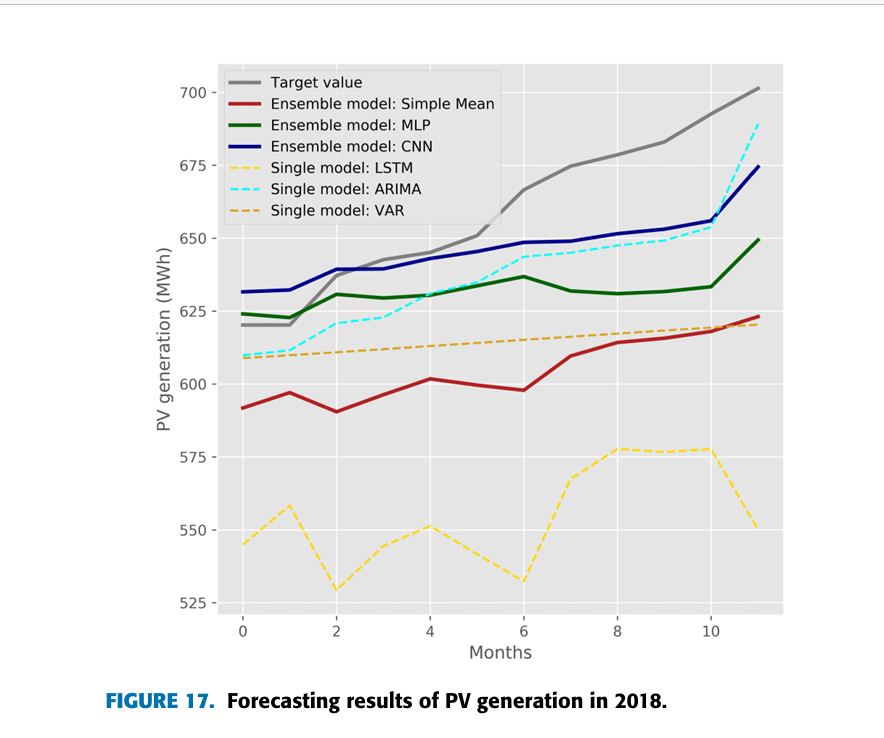